In [1]:
import pandas as pd

In [11]:
df = pd.read_csv("../../outputs/as4_results.csv")

In [12]:
df["qwen3_embedding_distance"] = df["qwen3_embedding_distance"].apply(lambda x: eval(x)["mean_distance"])
df["gemma_embedding_distance"] = df["gemma_embedding_distance"].apply(lambda x: eval(x)["mean_distance"])
df["luxembourgish_embedding_distance"] = df["luxembourgish_embedding_distance"].apply(lambda x: eval(x)["mean_distance"])

In [15]:
df = df.groupby(["model_name", "data_path"]).agg(
    case_count =("case_count", "mean"),
    bleu_mean=("bleu", "mean"),
    bleu_std=("bleu", "std"),
    length_ratio_mean=("length_ratio", "mean"),
    length_ratio_std=("length_ratio", "std"),
    rouge1_mean=("rouge1", "mean"),
    rouge1_std=("rouge1", "std"),
    embedding_distance_mean=("qwen3_embedding_distance", "mean"),
    embedding_distance_std=("qwen3_embedding_distance", "std")
).reset_index()

In [16]:
df = df.sort_values(by=["model_name", "data_path"], ascending=True)

In [19]:
# Rename Models for better visualization
model_name_mapping = {
    "Llama-3.1-8B-Instruct-as4": "Base Model",
    "Llama-3.1-8B-Instruct-eng-history-as4": "Fine-Tuned Model",
}

df["model_name"] = df["model_name"].map(model_name_mapping)

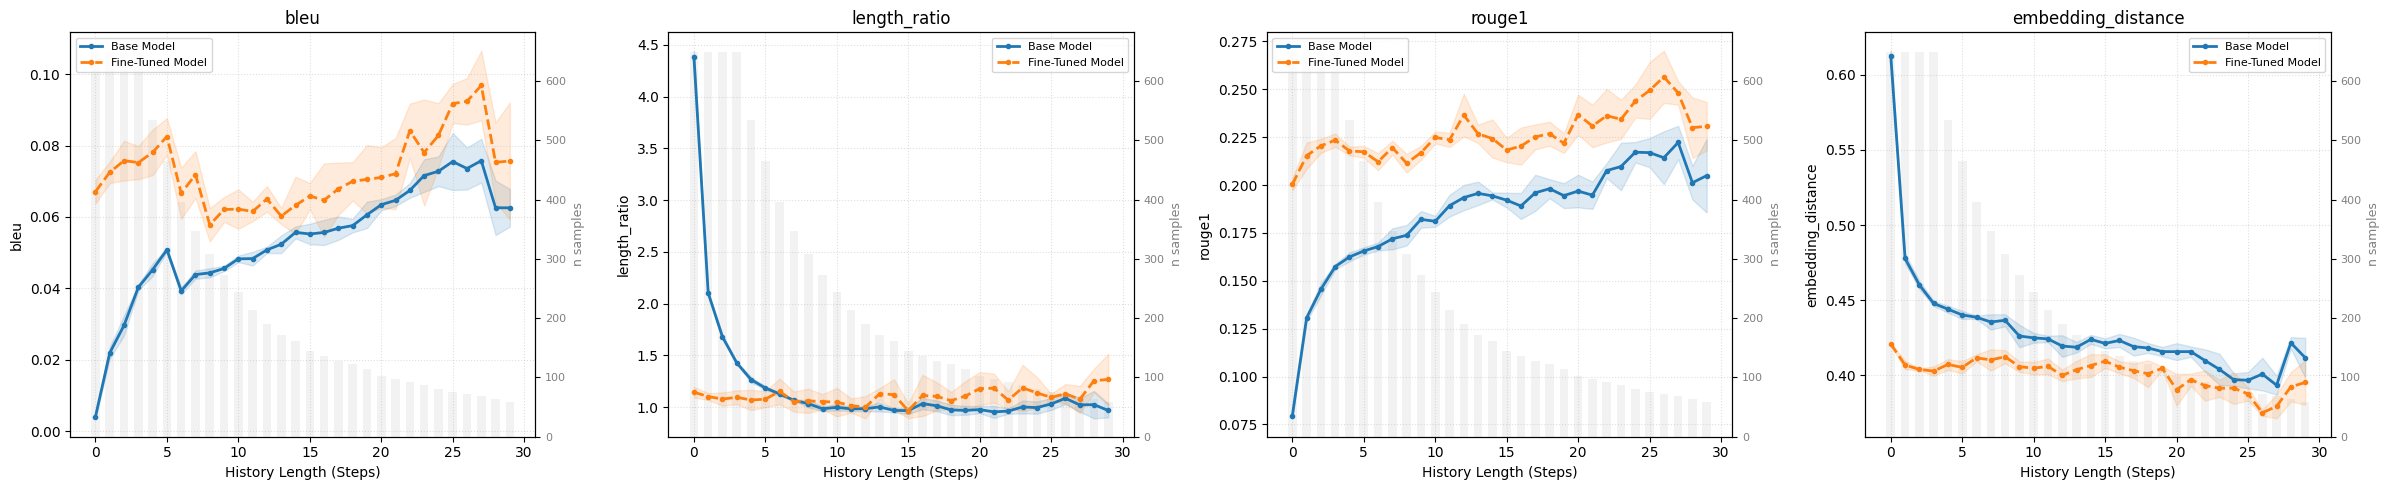

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# -----------------------------------------------------------------------------
# 1. PREPARE DATA
# -----------------------------------------------------------------------------
# Assuming your dataframe is named 'df'
# If loading from CSV: df = pd.read_csv("your_data.csv")

# Function to extract the history length (the number at the end of the filename)
def extract_history_length(path):
    # regex looks for pattern like "as4_10.json" and captures "10"
    match = re.search(r'_as4_(\d+)\.json', str(path))
    if match:
        return int(match.group(1))
    return 0 # Default fallback

# Apply extraction to get the X-axis value
df["history_length"] = df["data_path"].apply(extract_history_length)

# Sort by history length to ensure lines connect correctly
df = df.sort_values("history_length")

# -----------------------------------------------------------------------------
# 2. CONFIGURATION
# -----------------------------------------------------------------------------
# Define the root metrics you want to plot
# The script will automatically look for "_mean" and "_std" suffixes
metric_roots = ["bleu", "length_ratio", "rouge1", "embedding_distance"] 

# Define visual styles
# You can adjust these string checks to match your specific model naming conventions
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
linestyles = ["-", "--", "-.", ":"]

# Get unique models
models = df["model_name"].unique()

# -----------------------------------------------------------------------------
# 3. PLOTTING
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, len(metric_roots), figsize=(6 * len(metric_roots), 5), sharey=False)

if len(metric_roots) == 1:
    axes = [axes]

for ax, metric in zip(axes, metric_roots):
    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"
    
    # --- Secondary Axis for Sample Counts (Bars) ---
    # We take the sample counts from the first model to avoid duplicate bars
    # assuming all models are tested on the same dataset structure.
    ax2 = ax.twinx()
    first_model_data = df[df["model_name"] == models[0]].sort_values("history_length")
    
    ax2.bar(
        first_model_data["history_length"], 
        first_model_data["case_count"], 
        alpha=0.1, 
        color="gray", 
        width=0.6,
        label="n samples"
    )
    ax2.set_ylabel("n samples", color="gray", fontsize=9)
    ax2.tick_params(axis='y', labelcolor="gray", labelsize=8)
    ax2.set_zorder(1)  # Put bars behind
    ax.set_zorder(2)   # Put lines in front
    ax.patch.set_visible(False) # Make axis transparent so bars show through

    # --- Primary Axis for Metrics (Lines) ---
    for i, model_name in enumerate(models):
        subset = df[df["model_name"] == model_name]
        
        # X and Y data
        x = subset["history_length"]
        y = subset[mean_col]
        y_err = subset[std_col]
        
        # Determine style based on index or name
        # (Simple logic: iterate through color list)
        color = colors[i % len(colors)]
        style = linestyles[i % len(linestyles)]
        
        # Plot Shaded Region (Standard Deviation)
        ax.fill_between(
            x, 
            y - y_err, 
            y + y_err, 
            color=color, 
            alpha=0.15
        )
        
        # Plot Mean Line
        ax.plot(
            x, 
            y, 
            label=model_name, 
            color=color, 
            linestyle=style, 
            marker="o", 
            markersize=3, 
            linewidth=2
        )

    # Formatting
    ax.set_xlabel("History Length (Steps)")
    ax.set_ylabel(metric)
    ax.set_title(metric)
    
    # Ensure integer ticks on x-axis if range is small, or auto if large
    if df["history_length"].max() < 20:
        ax.set_xticks(df["history_length"].unique())
    
    ax.legend(fontsize=8, loc="best")
    ax.grid(True, linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()

fig.savefig("../../reports/metrics_by_history_length.png", dpi=300)

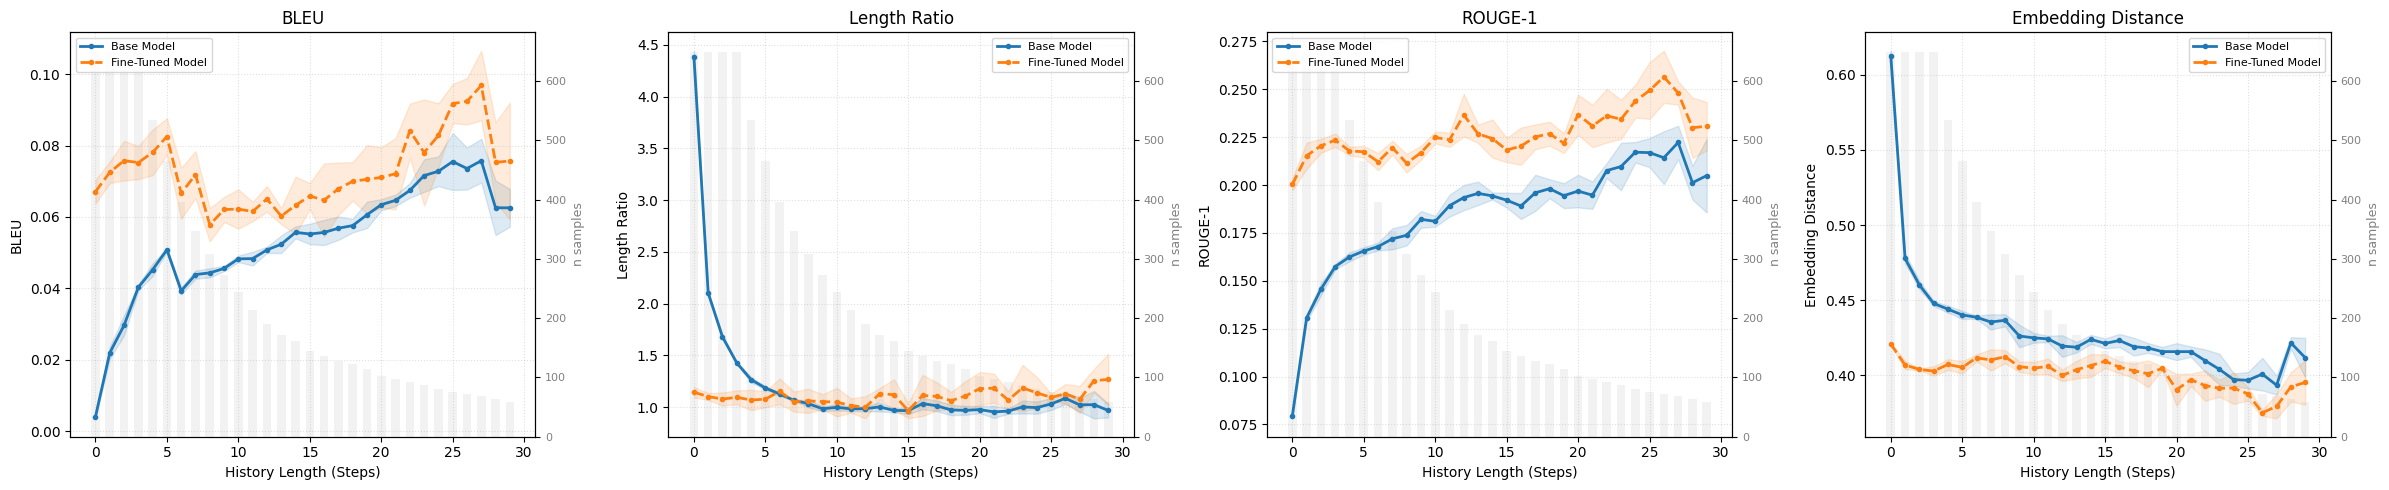

In [23]:
# Add pretty names for the metrics
pretty_metric_names = {
    "bleu": "BLEU",
    "length_ratio": "Length Ratio",
    "rouge1": "ROUGE-1",
    "embedding_distance": "Embedding Distance"
}

# -----------------------------------------------------------------------------
# 3. PLOTTING
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, len(metric_roots), figsize=(6 * len(metric_roots), 5), sharey=False)

if len(metric_roots) == 1:
    axes = [axes]

for ax, metric in zip(axes, metric_roots):
    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"
    
    # --- Secondary Axis for Sample Counts (Bars) ---
    ax2 = ax.twinx()
    first_model_data = df[df["model_name"] == models[0]].sort_values("history_length")
    ax2.bar(
        first_model_data["history_length"], 
        first_model_data["case_count"], 
        alpha=0.1, 
        color="gray", 
        width=0.6,
        label="n samples"
    )
    ax2.set_ylabel("n samples", color="gray", fontsize=9)
    ax2.tick_params(axis='y', labelcolor="gray", labelsize=8)
    ax2.set_zorder(1)
    ax.set_zorder(2)
    ax.patch.set_visible(False)

    # --- Primary Axis for Metrics (Lines) ---
    for i, model_name in enumerate(models):
        subset = df[df["model_name"] == model_name]
        x = subset["history_length"]
        y = subset[mean_col]
        y_err = subset[std_col]
        color = colors[i % len(colors)]
        style = linestyles[i % len(linestyles)]
        ax.fill_between(x, y - y_err, y + y_err, color=color, alpha=0.15)
        ax.plot(x, y, label=model_name, color=color, linestyle=style, marker="o", markersize=3, linewidth=2)

    ax.set_xlabel("History Length (Steps)")
    ax.set_ylabel(pretty_metric_names.get(metric, metric))
    ax.set_title(pretty_metric_names.get(metric, metric))
    if df["history_length"].max() < 20:
        ax.set_xticks(df["history_length"].unique())
    ax.legend(fontsize=8, loc="best")
    ax.grid(True, linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()
fig.savefig("../../reports/metrics_by_history_length.png", dpi=300)


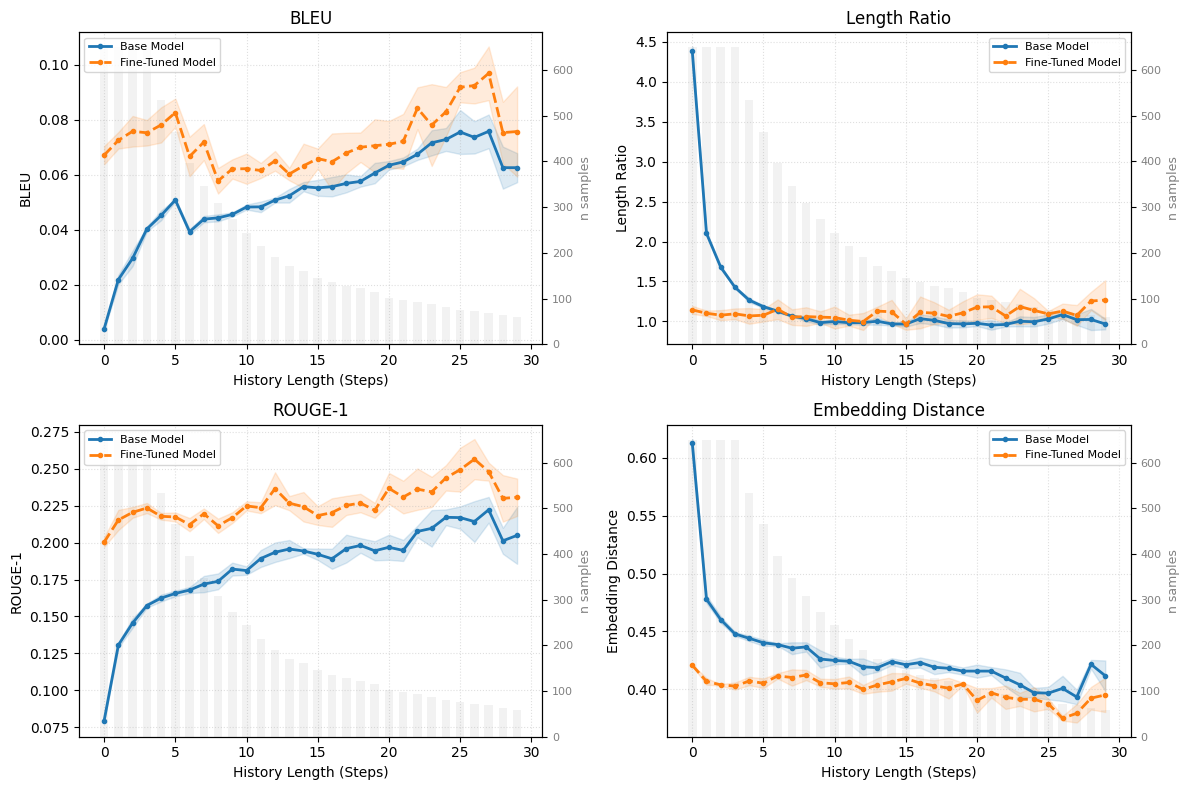

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=False)
axes = axes.flatten()

for ax, metric in zip(axes, metric_roots):
    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"
    
    ax2 = ax.twinx()
    first_model_data = df[df["model_name"] == models[0]].sort_values("history_length")
    ax2.bar(
        first_model_data["history_length"], 
        first_model_data["case_count"], 
        alpha=0.1, 
        color="gray", 
        width=0.6,
        label="n samples"
    )
    ax2.set_ylabel("n samples", color="gray", fontsize=9)
    ax2.tick_params(axis='y', labelcolor="gray", labelsize=8)
    ax2.set_zorder(1)
    ax.set_zorder(2)
    ax.patch.set_visible(False)

    # --- Primary Axis for Metrics (Lines) ---
    for i, model_name in enumerate(models):
        subset = df[df["model_name"] == model_name]
        x = subset["history_length"]
        y = subset[mean_col]
        y_err = subset[std_col]
        color = colors[i % len(colors)]
        style = linestyles[i % len(linestyles)]
        ax.fill_between(x, y - y_err, y + y_err, color=color, alpha=0.15)
        ax.plot(x, y, label=model_name, color=color, linestyle=style, marker="o", markersize=3, linewidth=2)

    ax.set_xlabel("History Length (Steps)")
    ax.set_ylabel(pretty_metric_names.get(metric, metric))
    ax.set_title(pretty_metric_names.get(metric, metric))
    if df["history_length"].max() < 20:
        ax.set_xticks(df["history_length"].unique())
    ax.legend(fontsize=8, loc="best")
    ax.grid(True, linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()
fig.savefig("../../reports/metrics_by_history_length.png", dpi=300)
